In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp
import matplotlib.pyplot as plt

In [2]:
INPUT_CSV = "plagiarism_pairs.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [3]:
df = pd.read_csv(INPUT_CSV)
print(f"Datos cargados: {len(df)} pares")

Datos cargados: 1312 pares


In [4]:
corpus = df['code1'].tolist() + df['code2'].tolist()

vectorizer = TfidfVectorizer(
    max_features=5000,  # Limitar número de características para evitar sobreajuste
    lowercase=False,     # Mantener mayúsculas/minúsculas (importante en Java)
    token_pattern=r'(?u)\b\w+\b'  # Tokens alfanuméricos (para capturar identificadores de Java)
)
vectorizer.fit(corpus)

X1 = vectorizer.transform(df['code1'])
X2 = vectorizer.transform(df['code2'])

# Combinar características (diferencia absoluta entre vectores TF-IDF)
X = sp.csr_matrix(np.abs(X1 - X2))  # Diferencia absoluta para capturar similitud

# Etiquetas
y = df['label'].values

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Escalar características (opcional, pero útil para algunos modelos)
scaler = StandardScaler(with_mean=False)  # with_mean=False para matrices dispersas
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
model = LogisticRegression(max_iter=50, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

LogisticRegression(max_iter=50, random_state=42)


Reporte de clasificación:
              precision    recall  f1-score   support

   No plagio       0.95      0.86      0.90       132
      Plagio       0.87      0.95      0.91       131

    accuracy                           0.91       263
   macro avg       0.91      0.91      0.91       263
weighted avg       0.91      0.91      0.91       263



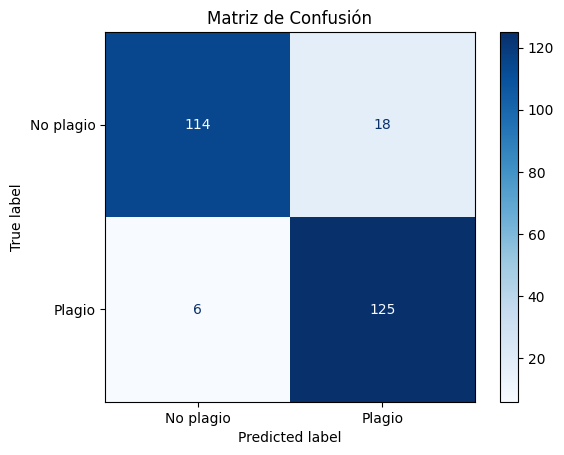

In [7]:
y_pred = model.predict(X_test)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['No plagio', 'Plagio']))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No plagio', 'Plagio'])
disp.plot(cmap='Blues')  # Usar paleta de colores 'Blues' (puedes cambiar a 'Reds', 'Greens', etc.)
plt.title('Matriz de Confusión')
plt.show()

## XGBOOST model


Reporte de clasificación (XGBoost con scale_pos_weight ajustado):
              precision    recall  f1-score   support

   No plagio       0.91      0.95      0.93       132
      Plagio       0.95      0.91      0.93       131

    accuracy                           0.93       263
   macro avg       0.93      0.93      0.93       263
weighted avg       0.93      0.93      0.93       263



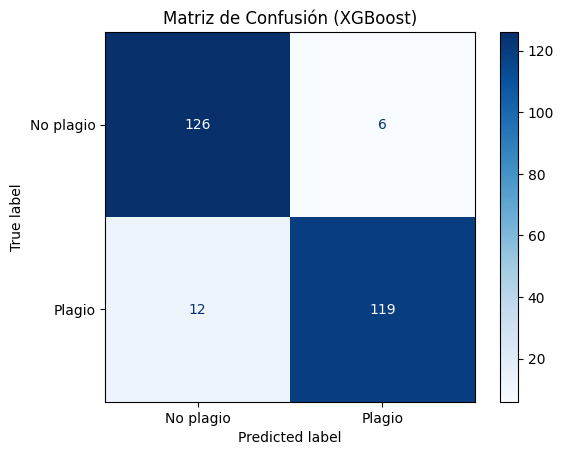

In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Aumentar peso de la clase "Plagio"
model = XGBClassifier(random_state=42)
model.fit(X_train, y_train)

# Predicciones con umbral ajustado
y_pred_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.4  # Ajusta si es necesario
y_pred = (y_pred_proba >= threshold).astype(int)

# Evaluación
print("\nReporte de clasificación (XGBoost con scale_pos_weight ajustado):")
print(classification_report(y_test, y_pred, target_names=['No plagio', 'Plagio']))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No plagio', 'Plagio'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusión (XGBoost)')
plt.show()